In [1]:
import numpy as np 
import pymc3 as pm
import theano.tensor as tt
import pymc3
import statistics
import matplotlib.pyplot as plt
import pandas as pd
from pyprojroot import here

ModuleNotFoundError: No module named 'pymc3'

In [2]:
mol_mass = {"CFC-11": 137.37,
            "CFC-12": 120.91,
            "CCl4": 153.82}

In [ ]:
Name of the inversion to calculate excess from

In [3]:
inv_name = "InversionMean"

Read in emissions data

In [4]:
years = np.arange(12)+2008
cfc11data = pd.read_csv(here() / f"Fig2_ExFig5_Emissions_csvs/2020-05-19_CFC-11_GSN+HAT_flat_{inv_name}.csv", skiprows=2)
cfc11 = cfc11data["Mean"].values
cfc11_sd = cfc11 - cfc11data["16th"].values

cfc12data = pd.read_csv(here() / f"Fig2_ExFig5_Emissions_csvs/2020-05-19_CFC-12_GSN_flat_{inv_name}.csv", skiprows=2)
cfc12 = cfc12data["Mean"].values
cfc12_sd = cfc12 - cfc12data["16th"].values
                             
ccl4data = pd.read_csv(here() / f"Fig2_ExFig5_Emissions_csvs/2020-05-19_CCL4_GSN_flat_{inv_name}.csv", skiprows=2)
ccl4 = ccl4data["Mean"].values
ccl4_sd = ccl4 - ccl4data["16th"].values   

Then get the integrated excess since 2013, asumming that "business as usual" is a linear decrease from 2012 mean until 2019

In [5]:
species = ["CFC-11", "CFC-12", "CCl4"]

species_excess = []
species_excess_sd = []
species_intercept = []
species_intercept_sd = []

wh_intercept = np.where((years > 2011) * (years < 2013))
wh_excess = np.where((years >= 2013) * (years < 2018))

x_excess = years[wh_excess] - np.mean(years[wh_intercept])

for m, sd in zip([cfc11, cfc12, ccl4], [cfc11_sd, cfc12_sd, ccl4_sd]):

    excess = []
    intercept_arr = []
    
    for it in range(100000):
        
        m_it = m + np.random.randn(len(m)) * sd

        intercept = np.mean(m_it[wh_intercept])
        gradient = (np.mean(m_it[np.where(years == 2019)]) - intercept) / (2019 - np.mean(years[wh_intercept]))

        excess.append(np.sum(m_it[wh_excess] - (gradient * x_excess + intercept)))
        intercept_arr.append(intercept)

    species_excess.append(statistics.mean(excess))
    species_excess_sd.append(statistics.stdev(excess))
    species_intercept.append(statistics.mean(intercept_arr))
    species_intercept_sd.append(statistics.stdev(intercept_arr))

In [6]:
burn = 5000
niter = 50000
tune = 10000

### Observations

They are:  <br>
1) Mean CFC-11 emissions from 2012 <br>
2) CFC-11 emissions in 2019 <br>
3) Total emissions from 2013-2018 <br>
4) Excess (above trendline) CFC-12 emissions <br>
5) Excess CCl4 emissions <br>

In [7]:
# Create Data array

Y = np.array([np.mean(cfc11[wh_intercept])/mol_mass["CFC-11"], 
              cfc11[-1]/mol_mass["CFC-11"], 
              np.sum(cfc11[wh_excess])/mol_mass["CFC-11"], 
              species_excess[1]/mol_mass["CFC-12"],
              species_excess[2]/mol_mass["CCl4"]])
Y_sd = np.array([np.mean(cfc11_sd[wh_intercept])/mol_mass["CFC-11"], 
              cfc11_sd[-1]/mol_mass["CFC-11"], 
              np.sqrt(np.sum(cfc11_sd[wh_excess]**2))/mol_mass["CFC-11"], 
              species_excess_sd[1]/mol_mass["CFC-12"],
              species_excess_sd[2]/mol_mass["CCl4"]])

In [8]:
nt = len(wh_excess[0])
T = np.arange(nt)[::-1]

### Model <br>
where T is the number of years in 2013-2018, and $\Delta B$ is the mean annual addition to the bank (assumed constant between 2013 and 2018) <br>
  $Q_{F11}^{2011-2012} = Bank_{2011-2012} * f_b $ <br>
  $Q_{F11}^{2019} = Bank_{2011-2012}*f_b*(1-f_b)^{T+1} + \Delta B*f_b*(\sum_{i=1}^{T} (1-f_b)^{i}) $ <br>
  $Q_{F11}^{2013-2018} =  P_{CFC-11} * f_{CFC-11} + \Delta B*f_b* \sum_{i=0}^{T-1} (T-i)*(1-f_b)^{i} + Bank_{2011-2012}*f_b* \sum_{i=1}^{T}(1-f_b)^{i} $<br>
  $Q_{CFC12} = P_{CFC-11} * R_{12/11}$ <br>
  $Q_{CCl4} = P_{CFC-11} * (R_{12/11} + 1) * CCl4_{release}$ <br>
 Then we can calculate the total excess by doing: <br>
 $Q_{totalexcess} = P_{CFC-11} * f_{CFC-11} + dB*f_b* \sum_{i=0}^{T-1} (T-i)*(1-f_b)^{i}$

In [9]:
def f(x1,x2,x4,x5,x6,x7):
    x3 = (1-x5)*x4/nt
    y1 = x1*x2
    y2 = x1*x2*(1-x2)**(nt+1) + x3*x2*pm.math.sum((1-x2)**(T+1))
    y3 = x4*x5 + x3*x2*pm.math.sum((nt-T)*(1-x2)**(T)) + x1*x2*pm.math.sum((1-x2)**(T+1))
    y4 = x4*x6
    y5 = x4*(1+x6)*x7   
    return tt.stack([y1,y2,y3,y4,y5])


with pm.Model() as model:
    x1 = pm.Uniform("Original bank", lower=Y[0], upper=100.*Y[0])
    x2 = pm.Uniform("Bank release fraction", lower=0.015, upper=0.042)
    x4 = pm.Uniform("CFC-11 production (Gg)", lower=species_excess[0]/mol_mass["CFC-11"], upper=100.*species_excess[0]/mol_mass["CFC-11"])
    x5 = pm.Uniform("CFC-11 release fraction", lower=0., upper=1.)
    x6 = pm.Uniform("CFC-11 / CFC-12 production ratio", lower=0., upper=1.)
    x7 = pm.Uniform("CCl4 release fraction", lower=0., upper=1.)
    mu = f(x1,x2,x4,x5,x6,x7)

    y = pm.MvNormal('y', mu=mu, cov=np.diag(Y_sd**2), observed=Y)
    trace = pm.sample(niter, tune=tune, target_accept=0.9)

    P_CFC11 = trace.get_values("CFC-11 production (Gg)", burn=burn, chains=1) * mol_mass["CFC-11"] #Back to Gg
    CFC11_release = trace.get_values("CFC-11 release fraction",burn=burn, chains=1) * 100.
    R_1211 = trace.get_values("CFC-11 / CFC-12 production ratio", burn=burn, chains=1) * 100.
    CCl4_release = trace.get_values("CCl4 release fraction", burn=burn, chains=1) * 100.
    bank_release = trace.get_values("Bank release fraction", burn=burn, chains=1) * 100.
    orig_bank = trace.get_values("Original bank", burn=burn, chains=1)* mol_mass["CFC-11"]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [CCl4 release fraction, CFC-11 / CFC-12 production ratio, CFC-11 release fraction, CFC-11 production (Gg), Bank release fraction, Original bank]
Sampling 2 chains, 92 divergences: 100%|██████████| 120000/120000 [09:28<00:00, 210.96draws/s]
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [10]:
dB = (1-CFC11_release/100.)*P_CFC11/nt
exbank_2019 = dB*np.sum(np.array([(1-bank_release/100.)**(t+1) for t in range(nt)]),axis=0)
totalbank_2019 = orig_bank*(1-bank_release/100.)**(nt+1) + exbank_2019 #dB*np.sum(np.array([(1-bank_release/100.)**(t+1) for t in range(nt)]),axis=0)
excess_total1318=P_CFC11*CFC11_release/100. + dB*bank_release/100.*np.sum(np.array([(nt-t)*(1-bank_release/100.)**(t) for t in range(nt)]),axis=0)
excess_total = excess_total1318 + exbank_2019*bank_release/100.

In [11]:
print("P_CFC11 = %0.1f (%0.1f - %0.1f) Gg" % (np.median(P_CFC11), *pm.stats.hpd(P_CFC11, 0.95)))
print("CFC11_release = %0.1f (%0.1f - %0.1f) %%" % (np.median(CFC11_release), *pm.stats.hpd(CFC11_release, 0.95)))
print("R_1211 = %0.1f (%0.1f - %0.1f) %%" % (np.median(R_1211), *pm.stats.hpd(R_1211, 0.95)))
print("CCl4_release = %0.1f (%0.1f - %0.1f) %%" % (np.median(CCl4_release), *pm.stats.hpd(CCl4_release, 0.95)))
print("bank_release = %0.1f (%0.1f - %0.1f) %%" % (np.median(bank_release), *pm.stats.hpd(bank_release, 0.95)))
print("Bank extra per year = %0.1f (%0.1f - %0.1f) Gg" % (np.median(dB), *pm.stats.hpd(dB, 0.95)))
print("Original bank = %i (%i - %i) Gg" % (np.median(orig_bank), *pm.stats.hpd(orig_bank, 0.95)))
print("Excess bank in 2019 = %0.1f (%0.1f - %0.1f) Gg" % (np.median(exbank_2019), *pm.stats.hpd(exbank_2019, 0.95)))
print("Excess emissions 2013-2018 = %0.1f (%0.1f - %0.1f) Gg" % (np.median(excess_total1318), *pm.stats.hpd(excess_total1318, 0.95)))
print("Excess emissions 2013-2019 = %0.1f (%0.1f - %0.1f) Gg" % (np.median(excess_total), *pm.stats.hpd(excess_total, 0.95)))
print("total 2019 bank = %0.1f (%0.1f - %0.1f) Gg" % (np.median(totalbank_2019), *pm.stats.hpd(totalbank_2019, 0.95)))

P_CFC11 = 53.1 (38.8 - 101.0) Gg
CFC11_release = 73.6 (38.6 - 100.0) %
R_1211 = 14.6 (0.0 - 31.9) %
CCl4_release = 30.1 (9.9 - 53.7) %
bank_release = 2.6 (1.5 - 4.0) %
Bank extra per year = 2.7 (0.0 - 12.0) Gg
Original bank = 227 (113 - 397) Gg
Excess bank in 2019 = 12.7 (0.0 - 55.8) Gg
Excess emissions 2013-2018 = 40.8 (29.7 - 52.5) Gg
Excess emissions 2013-2019 = 41.2 (30.3 - 53.5) Gg
total 2019 bank = 212.2 (103.4 - 377.5) Gg


# ODP and GWP

In [12]:
excess_total = np.copy(excess_total1318)
nsamp = len(excess_total)
odps = {"CFC-11":1,"CFC-12":0.77, "CCl4":0.89}
gwps = {"CFC-11":5160,"CFC-12":10300, "CCl4":2100}
ODP = excess_total + odps["CFC-12"]*np.random.normal(species_excess[1],species_excess_sd[1],nsamp) + odps["CCl4"]*np.random.normal(species_excess[2],species_excess_sd[2],nsamp)
GWP = gwps["CFC-11"]*excess_total + gwps["CFC-12"]*np.random.normal(species_excess[1],species_excess_sd[1],nsamp) + gwps["CCl4"]*np.random.normal(species_excess[2],species_excess_sd[2],nsamp)

ODP_allproduction = P_CFC11 + odps["CFC-12"]*np.random.normal(species_excess[1],species_excess_sd[1],nsamp) + odps["CCl4"]*np.random.normal(species_excess[2],species_excess_sd[2],nsamp)

print("ODP of excess = %0.1f (%0.1f - %0.1f) Gg" % (np.median(ODP), *pm.stats.hpd(ODP, 0.95)))
print("ODP all production = %0.1f (%0.1f - %0.1f) Gg" % (np.median(ODP_allproduction), *pm.stats.hpd(ODP_allproduction, 0.95)))
print("GWP-100 of excess = %0.1f (%0.1f - %0.1f) Gg" % (np.median(GWP), *pm.stats.hpd(GWP, 0.95)))

ODP of excess = 66.2 (49.5 - 82.7) Gg
ODP all production = 79.5 (54.9 - 129.9) Gg
GWP-100 of excess = 335095.3 (233655.1 - 440279.1) Gg


Calculate the total excess emissions:

In [13]:
total_added_to_bank = (1-CFC11_release/100.)*P_CFC11

In [14]:
print("total_added_to_bank = %0.1f (%0.1f - %0.1f) Gg" % (np.median(total_added_to_bank), *pm.stats.hpd(total_added_to_bank, 0.95)))

total_added_to_bank = 13.7 (0.0 - 60.1) Gg


# Qualitatively check for convergence

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d6edf98>,
      dtype=object)

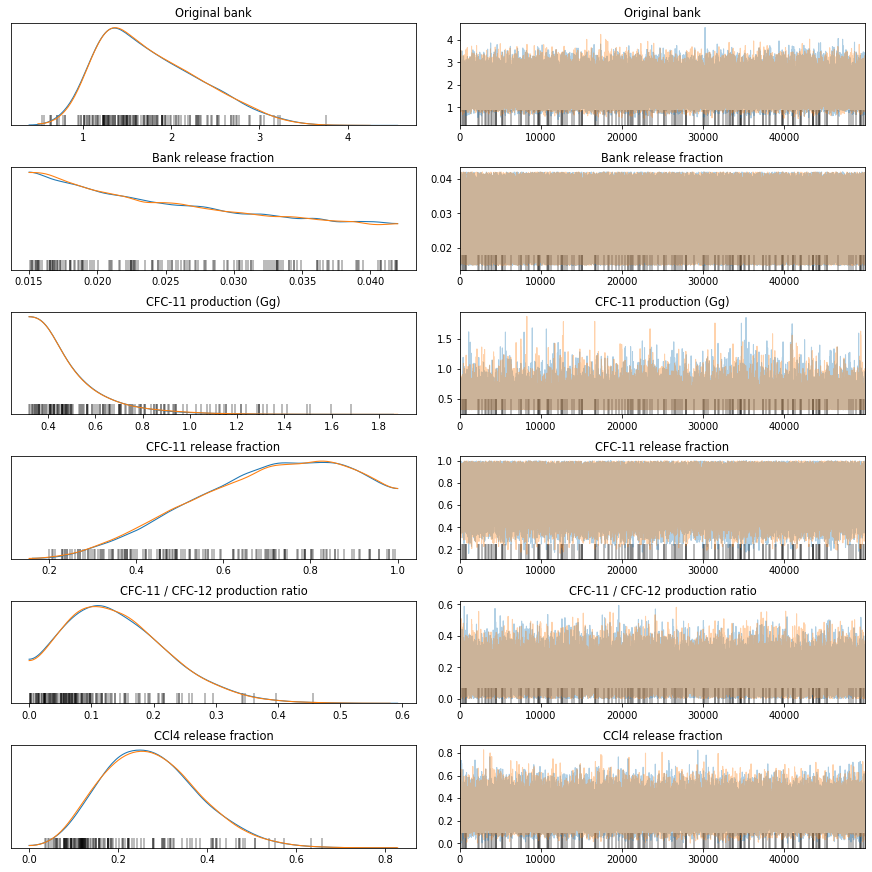

In [15]:
pm.traceplot(trace)